In [ ]:
# This code is part of qhack2022-hackeinberg-project.
#
# (C) Copyright NTNU QuCAI-Lab, 2022.
#
# This code is licensed under the Creative Commons Zero v1.0 Universal License. 
# You may obtain a copy of the License at https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/blob/dev/LICENSE.md.

[![Maintenance](https://img.shields.io/badge/Maintained%3F-yes-green.svg)](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/graphs/commit-activity)
[![Build Status](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/actions/workflows/tests.yml/badge.svg?branch=dev)](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/actions/workflows/tests.yml)
[![Release](https://img.shields.io/github/release/QuCAI-Lab/qhack2022-hackeinberg-project.svg)](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/releases)
[![commit](https://img.shields.io/github/last-commit/QuCAI-Lab/qhack2022-hackeinberg-project)](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/commits)
[![Forks](https://img.shields.io/github/forks/QuCAI-Lab/qhack2022-hackeinberg-project)](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/fork)

<div align="center">
  <h1> <a href="https://qhack.ai/events#hackathon-challenges"> QHack2022 Open Hackaton </a> - Hackeinberg Team Project </h1>
  <h2> Extending Adaptive Methods for Finding an Optimal Circuit Ansatze in VQE Optimization</h2>
</div>
<br>

<center> <b>Authors: ¹Lucas Camponogara Viera, ²José Paulo Marchezi</b></center>
<center>
<b><a target="_blank" href="https://en.ntnu.edu.tw/">¹National Taiwan Normal University - NTNU, Taipei, Taiwan</a></b>.
<br>
<b><a target="_blank" href="https://www.gov.br/inpe/pt-br">²National Institute for Space Research - INPE, São José dos Campos, SP, Brazil.</a></b>.
<br>
<b><a target="_blank" href="http://english.nssc.cas.cn/">²State  Key  Laboratory  of  Space  Weather,  National  Space  Science  Center, Chinese  Academy  of  Sciences, China</a></b>.
</center>

<br>

[comment]: <> ()
<table class="tfo-notebook-buttons" align="head">
  <td>
    <a target="_blank" href="https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /></a>
  </td>
</table>

<center><a href="https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project"><b>View source on GitHub.</b></a></center>

    


In [ ]:
%autosave 30

Autosaving every 30 seconds


---

In this jupyter notebook, the authors describe a step-by-step implementation of a hybrid quantum-classical optimization approach to find the optimal gate arrangement of a problem-specific ansatze (quantum circuit). We demonstrate the variational circuit approach to find the ground state of the LiH molecule considering only single and double excitations.

---

# **Project Description**


## Background and Motivation


Most widely considered hardware-efficient and Chemistry-inspired ansatze, although generic, suffer from either barren plateaus [[1](https://www.nature.com/articles/s41467-018-07090-4)] or inconsistency under low-order trotterization steps [[2](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.9b01083)], respectively. To circumvent this drawback, different algorithms for optimization of variational quantum circuits (VQA), the so-called adaptive circuits, have already been proposed in the literature [[4](https://pennylane.ai/qml/demos/tutorial_adaptive_circuits.html)]. One example is the Adaptive Derivative-Assembled Pseudo-Trotter ansatz Variational Quantum Eigensolver (ADAPT-VQE) [[3](https://www.nature.com/articles/s41467-019-10988-2)]. In a nutshell, the ADAPT-VQE approach is to grow the ansatz by adding fermionic operators one-at-a-time so to preserve the amount of correlation energy. This approach can also be regarded as a particular optimization procedure for Full Configuration Interaction (FCI) VQE.

In this work, we combine some of the existing methods applied to the hybrid quantum-classical VQE [[5](https://doi.org/10.1038/ncomms5213)] algorithm for the particular case of the ground state of the LiH molecule. We prioritize the minimization of the circuit depth (the longest sequence of gates acting on a qubit register) at the cost of increasing parameter count (the number of parameters to be optimized) given the tradeoff between difficulty in implementation on NISQ devices vs difficulty in optimization on classical computers, respectively. The baseline approach took into consideration the following features for a good ansatz:

1. Coherence friendly: the circuit must be shallow, i.e, have a small number of layers in order to be computed during a time window smaller than the decoherence time.
2. Hardware friendly (qubit routing): gate coupling allowed only between nearest-neighbor qubits to avoid SWAP gates during qubit routing (mapping from the circuit diagram to a hardware topology).
3. Small number of hyperparameters: we seek the minimum amount of angles to be optimized in order to avoid classical optimization overhead (when classical computation becomes too expensive).

In its early stages, the goal is to find a quasi-optimal ansatz by restricting the VQE simulation to single and double order excitations only. For the future, we plan to use a deep reinforcement learning approach to learn an exact circuit ansatz considering higher excitation orders and the [Qamuy SDK](https://qamuy.qunasys.com/docs/en/).




## Algorithm outline

1. With the spin orbitals of the molecule of interest, compute its second-quantized electronic Hamiltonian in the STO-3G basis.

2. Map the fermionic Hamiltonian given in terms of its fermionic operators into a spin qubit-equivalent Hamiltonian using either Bravyi-Kitaev or the inverted Jordan–Wigner transformation. This is required to perform gate-based quantum computation. The Hamiltonian will be used to compute the cost function that evaluate the expectation value of the Hamiltonian, while the number of qubits is required to obtain the electronic excitations and to set up the quantum circuit.

3. Obtain the single and double electronic excitations by acting with the electron annihilation and creation operators on the Hartree-Fock reference state.

4. Define a set with all unique single and double excitations to create the correspondent SO(2) unitary qubit gates (the particular Givens rotations) to each electronic excitation operator in order to build a quantum circuit ansatz of particle-conserving unitary qubit gates.

5. Initialize the qubit state to a reference Hartree-Fock state.

6. Initialize the parameter values of each gate in the ansatz to zero, i.e, initialize the ansatz to the identity matrix in order to compute the gradients with respect to the Hartree-Fock state.

7. Prepare the trial estate with the current ansatz.

8. Define the cost function as the expectation value of the qubit Hamiltonian. Define an optimizer (e.g. SGD).

9. Use the parameter shift rule to compute the gradient of the cost function with respect to its tunable parameters.

10. Identify the operators (gates) with the largest gradient. Add to the ansatz the gate whose gradient is the largest. Remove gates whose gradient are smaller than a pre-defined threshold.

11.  Use the optimizer to update the circuit parameters according to a VQE experiment.

12. Define the convergence as the difference between the previous and the next expected value for the current optimization step. If the convergence tolerance is less than or equal to a pre-defined threshold $\epsilon$, exit the optimization loop and evaluate the cost metric of the final optimized circuit by measuring its circuit depth.

13. Repeat step 9.

## Outlook

For the future, we plan to use a deep reinforcement learning approach to learn an exact circuit ansatz considering higher excitation orders.

# &nbsp; <a href="https://creativecommons.org/licenses/by/4.0/"><img valign="middle" src="https://img.icons8.com/copyright" width="50"></a> License

# &nbsp; <a href="#"><img valign="middle" height="45px" src="https://img.icons8.com/python" width="45" hspace="0px" vspace="0px"></a> Dependencies

One may find the `requirements.txt` file at the official [GitHub repo](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/blob/dev/requirements.txt).


## pip install

**Installing `Qamuy`, `PennyLane`, `pennylane-qchem`, `pyscf`, `openfermionpyscf`, `pylatexenc`, and `Watermak`.**



In [ ]:
!pip --version

pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)


In [ ]:
'''
# Installing a non-default library

!python3 -m pip install <library_name>

# Alternative 

!apt-get -qq install -y <library_name> && pip install -U <library_name> 

# Upgrading an installed library

!pip install <library_name> --upgrade
'''

'\n# Installing a non-default library\n\n!python3 -m pip install <library_name>\n\n# Alternative \n\n!apt-get -qq install -y <library_name> && pip install -U <library_name> \n\n# Upgrading an installed library\n\n!pip install <library_name> --upgrade\n'

**Qamuy:**

In [ ]:
!python3 -m pip install qamuy-client --extra-index-url https://download.qamuy.qunasys.com/simple/

Looking in indexes: https://pypi.org/simple, https://download.qamuy.qunasys.com/simple/
User for download.qamuy.qunasys.com: qamuy
Password: 
     |████████████████████████████████| 77 kB 1.6 MB/s 
     |████████████████████████████████| 46 kB 2.1 MB/s 
     |████████████████████████████████| 3.6 MB 10.2 MB/s 
     |████████████████████████████████| 1.1 MB 41.1 MB/s 
     |████████████████████████████████| 454 kB 24.8 MB/s 
     |████████████████████████████████| 2.0 MB 47.2 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 82 kB 1.0 MB/s 
  Created wheel for gcloud: filename=gcloud-0.18.3-py3-none-any.whl size=602937 sha256=fabbb2b30917d1f266c7bc1d584f3d416e24c8107826ee7103e36869946b08bd
  Stored in directory: /root/.cache/pip/wheels/50/9d/19/dc1a639905431252dbf8a61388a83459c5cfef7add445bebe4
Successfully built gcloud
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
 

**PennyLane:**

In [ ]:
!python3 -m pip install PennyLane==0.21.0

In [ ]:
!python3 -m pip install pennylane-qchem

**pyscf**:

In [ ]:
!python3 -m pip install pyscf --user

**Open Fermion**:

In [ ]:
!python3 -m pip install openfermionpyscf==0.5

**Native numpy:**

In [ ]:
#!python -m pip install numpy==1.20.3

**pylatexenc**:

In [ ]:
!python -m pip install pylatexenc

     |████████████████████████████████| 162 kB 24.2 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136835 sha256=51a2d1acc4bd5ea21cd0a7154d029e8fc430eef9dfec8b4203a7228cde0712fa
  Stored in directory: /root/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built pylatexenc


**Watermark:**

In [ ]:
!python -m pip install watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.1
    Uninstalling importlib-metadata-4.11.1:
      Successfully uninstalled importlib-metadata-4.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


## Importing libraries


In [ ]:
#import qamuy.chemistry as qy
#from qamuy.client import Client
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import IPython
import sys
import time

In [ ]:
%load_ext watermark
%watermark -a 'Lucas Camponogara Viera' -gu 'camponogaraviera' -ws 'https://qucai-lab.github.io/' -w -u -d -v -m -iv -r -b

In [ ]:
qml.about()

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Name: PennyLane
Version: 0.21.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: None
Author-email: None
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: retworkx, toml, cachetools, appdirs, autograd, networkx, numpy, semantic-version, autoray, pennylane-lightning, scipy
Required-by: PennyLane-Qchem, PennyLane-Lightning
Platform info:           Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic
Python version:          3.7.12
Numpy version:           1.21.5
Scipy version:           1.4.1
Installed devices:
- default.gaussian (PennyLane-0.21.0)
- default.mixed (PennyLane-0.21.0)
- default.qubit (PennyLane-0.21.0)
- default.qubit.autograd (PennyLane-0.21.0)
- default.qubit.jax (PennyLane-0.21.0)
- default.qubit.tf (PennyLane-0.21.0)
- default.qubit.torch (PennyLane-0.21.0)
- lightning.qubit (PennyLane-Lightning-0.21.0)


In [ ]:
print(IPython.sys_info())

{'commit_hash': 'b467d487e',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/usr/local/lib/python3.7/dist-packages/IPython',
 'ipython_version': '5.5.0',
 'os_name': 'posix',
 'platform': 'Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.7.12 (default, Jan 15 2022, 18:48:18) \n[GCC 7.5.0]'}


# &nbsp; <a href="#"><img valign="middle" height="45px" src="https://img.icons8.com/physics" width="45" hspace="0px" vspace="0px"></a> Implementation

**Definitions**

- symbols: a list os strings describing the atoms of the molecule.
- geometry: a 1D numpy tensor defining the orbital coordinates of the molecule.
- H: the molecular Hamiltonian of the system in the qubit representation.
- qubits: the number of qubits (int).
- electrons: the number of active electrons for simulation (int).
- singles: a list of 8 elements where each element is another list with 2 indices of the spin orbitals.
- doubles: a list of 16 elements where each element is another list with 4 indices of the spin orbitals.
- sets: a list containing the total spin orbital indices used to build the Givens rotations a.k.a particle-preserving operators (qubit gates).
- HF:  a numpy.ndarray of shape ((10,) representing the Hartree-Fock state vector.
- params: a numpy tensor containing the angles to be optimized.
- energy: a list containing the optimized expected values of the Hamiltonian.
- opt: the optimizer (e.g., SGD, Adam, Adagrad, etc.).
- dev: the PennyLane Python module defining the simulator type.
- cost(): a function that returns the expectation value of the Hamiltonian according to $\langle \psi_{HF}|U^{\dagger}HU|\psi_{HF}\rangle$.
- ansatz(): a function defining the quantum circuit and parametrized gates to be optimized.

- grads: a <class 'numpy.ndarray'> of shape sets.shape containing the gradient of the cost function w.r.t the angle of each gate.




## Pennylane

**Algorithm**

- Steps 1 and 2 are implemented with the qchem.molecular_hamiltonian() function that returns both the fermionic-to-qubit transformed Hamiltonian and the number of qubits.

- Step 3 is implemented using the qchem.excitations() function.

- Step 4 are implemented with the SingleExcitation() and DoubleExcitation() classes, respectively, by passing the return of the qchem.excitations() function, i.e, the lists with the indices of the spin orbitals.

- Step 5 is implemented with the qml.BasisState class provided the HF state is obtained with the function qchem.hf_state function.

- Step 6 is a simple numpy tensor.

- At step 8, the cost function can be implemented either with the built-in ExpvalCost() class or as a custom function returning the expectation value of the circuit with the expval() class. The primary optimizer of choice is SGD defined by the GradientDescentOptimizer(stepsize=float) class.

- Step 9 is implemented with the grad() class. 

- Step 11 is computed using the GradientDescentOptimizer.step() method.

### Adding one gate at a time

In [11]:
#! /usr/bin/python3

import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import time

def penny_simulation(params, H, HF, sets, qubits, conv_tol, threshold):
  """Main function to run the optimization loop.

  Args:
      - params (tensor): the parameters to be optimized in the ansatz.
      - H: the molecular Hamiltonian of the system in the qubit representation.
      - HF (numpy.ndarray): the Hartree-Fock state vector.
      - sets (list): total spin orbital indices used to build the Givens rotations a.k.a particle-preserving operators (qubit gates).
      - qubits (int): the number of qubits used to build the circuit.

  Returns:
      - energy (list): a list of expected values of each iteration.
      - sets (list): a list of excitations corresponding to the gates used in the final circuit.
      - params (list): a list of optimized parameters.
      - n (int): number of epochs.
  """

  def ansatz(params, wires, to_gates):
    """Function that defines the circuit to be optimized."""
    qml.BasisState(HF, wires=wires) # The reference Hartree-Fock state.
    for i, elem in enumerate(to_gates):
      if len(elem) == 4:
        qml.DoubleExcitation(params[i], wires=elem)
      else:
        qml.SingleExcitation(params[i], wires=elem)
  
  # Step 8.
  opt = qml.GradientDescentOptimizer(stepsize=0.4)  
  dev = qml.device("default.qubit", wires=qubits)
  #@qml.qnode(dev, diff_method="parameter-shift")
  #def cost(params):
    #"""The cost function."""
    #ansatz(params, wires=range(qubits), to_gates=sets)
    #return qml.expval(qml.SparseHamiltonian(H_sparse, wires=range(qubits)))

  cost = qml.ExpvalCost(ansatz, H, dev, optimize=True)
  circuit_gradient = qml.grad(cost, argnum=0)
  epochs = 50
  energy = [cost(params, to_gates=sets)]
  print(f"Epoch = 0,  Energy = {energy[-1]:.8f} Ha, t = 0s")
  print("Number of gates = {}\n".format(len(sets)))

  for n in range(epochs):
    t1 = time.time()

    grads = circuit_gradient(params,to_gates=sets) # Step 9.
    maxpos = np.argmax(grads) # Beginning of Step 10.
    max=sets[maxpos]
    sets.append(max)
    params=np.append(params, 0) # End of step 10.
    
    params, prev_energy = opt.step_and_cost(cost, params, to_gates=sets) # Step 11.
    energy.append(cost(params, to_gates=sets))
    conv = np.abs(-7.8825378193 - prev_energy) # Step 12.
    t2 = time.time()
    print(f"Epoch = {n+1}, Energy = {energy[-1]:.8f} Ha, t = {t2-t1:.2f}s")
    print("Number of gates = {}\n".format(len(sets)))
    if conv <= conv_tol:
      break
  return energy, sets, params

if __name__ == "__main__":
  symbols = ["Li", "H"] # Beginning of step 1.
  geometry = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 2.969280527], dtype=float)
  H, qubits = qml.qchem.molecular_hamiltonian(symbols, geometry, active_electrons=2, active_orbitals=5) # End of step 2.
  electrons = 2
  singles, doubles = qchem.excitations(electrons, qubits) # Step 3.
  sets = singles+doubles # Step 4.
  HF = qml.qchem.hf_state(electrons, qubits) # Step 5.
  params = np.zeros(len(sets), requires_grad=True) # Beginning of step 6.
  conv_tol=1e-04
  energy, sets, angles = optimize(params, H, HF, sets, qubits, conv_tol, threshold=1.0e-4) # Beginning of the optimization loop.
  print("Expected ground-state energy: -7.8825378193.")
  print(f"Simulation = {energy[-1]:.8f} Ha")

Epoch = 0,  Energy = -7.86266587 Ha, t = 0s
Number of gates = 24

Epoch = 1, Energy = -7.86985383 Ha, t = 18.77s
Number of gates = 25

Epoch = 2, Energy = -7.87450290 Ha, t = 23.13s
Number of gates = 26

Epoch = 3, Energy = -7.87733380 Ha, t = 23.63s
Number of gates = 27

Epoch = 4, Energy = -7.87904365 Ha, t = 21.54s
Number of gates = 28

Epoch = 5, Energy = -7.88011206 Ha, t = 22.21s
Number of gates = 29

Epoch = 6, Energy = -7.88079852 Ha, t = 22.53s
Number of gates = 30

Epoch = 7, Energy = -7.88124764 Ha, t = 23.33s
Number of gates = 31

Epoch = 8, Energy = -7.88154767 Ha, t = 22.71s
Number of gates = 32

Epoch = 9, Energy = -7.88175335 Ha, t = 23.21s
Number of gates = 33

Epoch = 10, Energy = -7.88189845 Ha, t = 24.22s
Number of gates = 34

Epoch = 11, Energy = -7.88200372 Ha, t = 24.17s
Number of gates = 35

Epoch = 12, Energy = -7.88208206 Ha, t = 23.95s
Number of gates = 36

Epoch = 13, Energy = -7.88214162 Ha, t = 24.11s
Number of gates = 37

Epoch = 14, Energy = -7.88218776 

**Final Ansatz Visualization:**

In [12]:
print("Expected ground-state energy: -7.8825378193.")
print(f"Simulation = {energy[-1]:.8f} Ha")
print(f"Convergence = {conv_tol:.4f} Ha")

Expected ground-state energy: -7.8825378193.
Simulation = -7.88242812 Ha
Convergence = 0.0001 Ha


In [13]:
angles.shape, len(sets)

((74,), 74)

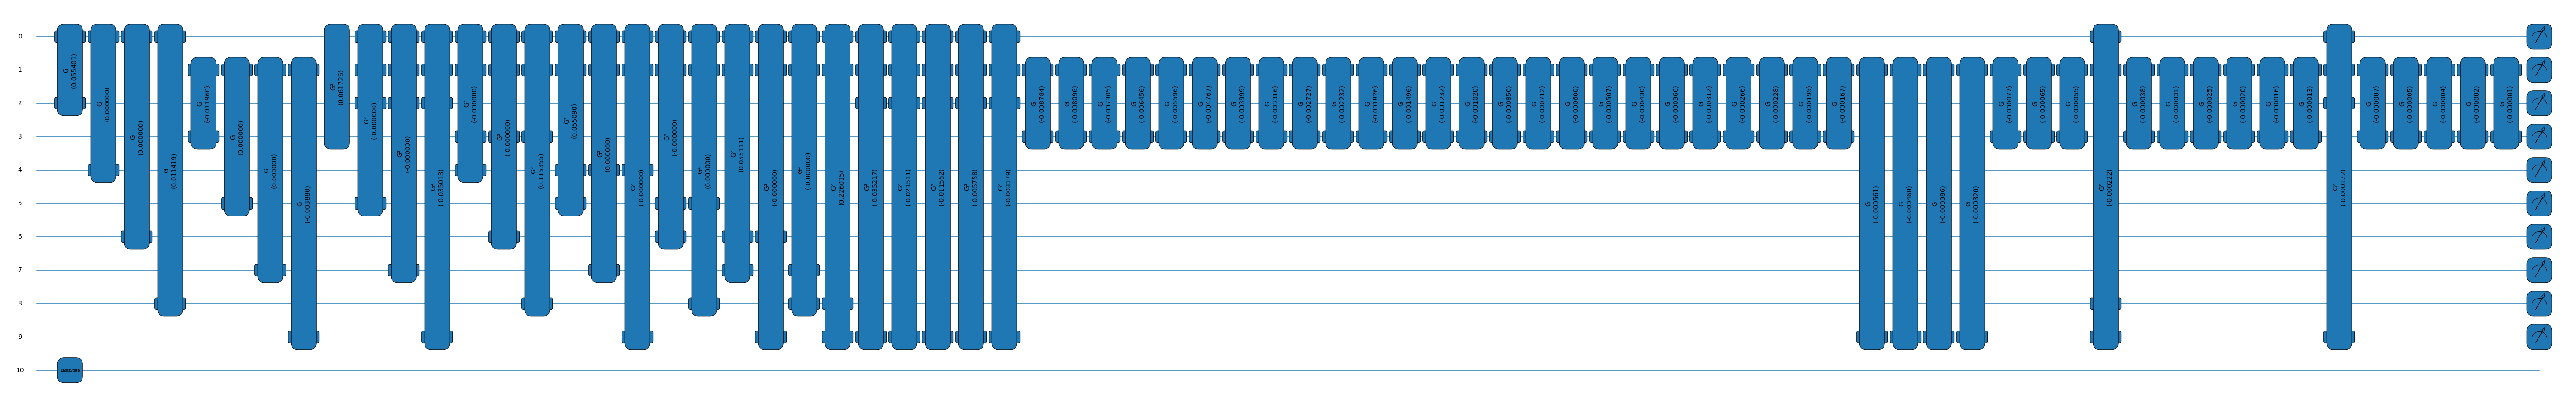

In [14]:
dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev)
def ansatz(params, wires, to_gates=sets):
  """Function that defines the circuit to be optimized."""
  qml.BasisState(HF, wires=wires) # Reference Hartree-Fock state.
  for i, elem in enumerate(to_gates):
    if len(elem) == 4:
      qml.DoubleExcitation(angles[i], wires=elem)
    else:
      qml.SingleExcitation(angles[i], wires=elem)
  return qml.expval(H)

fig, ax = qml.draw_mpl(ansatz, decimals=6)(params, wires=qubits)

In [15]:
sets

[[0, 2],
 [0, 4],
 [0, 6],
 [0, 8],
 [1, 3],
 [1, 5],
 [1, 7],
 [1, 9],
 [0, 1, 2, 3],
 [0, 1, 2, 5],
 [0, 1, 2, 7],
 [0, 1, 2, 9],
 [0, 1, 3, 4],
 [0, 1, 3, 6],
 [0, 1, 3, 8],
 [0, 1, 4, 5],
 [0, 1, 4, 7],
 [0, 1, 4, 9],
 [0, 1, 5, 6],
 [0, 1, 5, 8],
 [0, 1, 6, 7],
 [0, 1, 6, 9],
 [0, 1, 7, 8],
 [0, 1, 8, 9],
 [0, 1, 2, 9],
 [0, 1, 2, 9],
 [0, 1, 2, 9],
 [0, 1, 2, 9],
 [0, 1, 2, 9],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 9],
 [1, 9],
 [1, 9],
 [1, 9],
 [1, 3],
 [1, 3],
 [1, 3],
 [0, 1, 8, 9],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [0, 1, 2, 9],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3]]

### Comparing optimization for a fixed ansatz

In [7]:
#! /usr/bin/python3

import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import time

def penny_simulation(params, H, HF, sets, qubits, conv_tol, threshold):
  """Main function to run the optimization loop.

  Args:
      - params (tensor): the parameters to be optimized in the ansatz.
      - H: the molecular Hamiltonian of the system in the qubit representation.
      - HF (numpy.ndarray): the Hartree-Fock state vector.
      - sets (list): total spin orbital indices used to build the Givens rotations a.k.a particle-preserving operators (qubit gates).
      - qubits (int): the number of qubits used to build the circuit.

  Returns:
      - energy (list): a list of expected values of each iteration.
      - sets (list): a list of excitations corresponding to the gates used in the final circuit.
      - params (list): a list of optimized parameters.
      - n (int): number of epochs.
  """

  def ansatz(params, wires, to_gates):
    """Function that defines the circuit to be optimized."""
    qml.BasisState(HF, wires=wires) # The reference Hartree-Fock state.
    for i, elem in enumerate(to_gates):
      if len(elem) == 4:
        qml.DoubleExcitation(params[i], wires=elem)
      else:
        qml.SingleExcitation(params[i], wires=elem)
  
  # Step 8.
  opt = qml.GradientDescentOptimizer(stepsize=0.4)  
  dev = qml.device("default.qubit", wires=qubits)

  cost = qml.ExpvalCost(ansatz, H, dev, optimize=True)
  circuit_gradient = qml.grad(cost, argnum=0)
  epochs = 25
  energy = [cost(params, to_gates=sets)]
  print(f"Epoch = 0,  Energy = {energy[-1]:.8f} Ha, t = 0s")
  print("Number of gates = {}\n".format(len(sets)))

  for n in range(epochs):
    t1 = time.time()

    grads = circuit_gradient(params,to_gates=sets) # Step 9.
    #maxpos = np.argmax(grads) # Beginning of Step 10.
    #max=sets[maxpos]
    #sets.append(max)
    #params=np.append(params, 0) # End of step 10.

    params, prev_energy = opt.step_and_cost(cost, params, to_gates=sets) # Step 11.
    energy.append(cost(params, to_gates=sets))
    conv = np.abs(-7.8825378193 - prev_energy) # Step 12.
    t2 = time.time()
    print(f"Epoch = {n+1}, Energy = {energy[-1]:.8f} Ha, t = {t2-t1:.2f}s")
    print("Number of gates = {}\n".format(len(sets)))
    if conv <= conv_tol:
      break
  return energy, sets, params

if __name__ == "__main__":
  symbols = ["Li", "H"] # Beginning of step 1.
  geometry = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 2.969280527], dtype=float)
  H, qubits = qml.qchem.molecular_hamiltonian(symbols, geometry, active_electrons=2, active_orbitals=5) # End of step 2.
  electrons = 2
  singles, doubles = qchem.excitations(electrons, qubits) # Step 3.
  sets = singles+doubles # Step 4.
  HF = qml.qchem.hf_state(electrons, qubits) # Step 5.
  params = np.zeros(len(sets), requires_grad=True) # Beginning of step 6.
  conv_tol=1e-04
  energy, sets, angles = optimize(params, H, HF, sets, qubits, conv_tol, threshold=1.0e-4) # Beginning of the optimization loop.
  print("Expected ground-state energy: -7.8825378193.")
  print(f"Simulation = {energy[-1]:.8f} Ha")

Epoch = 0,  Energy = -7.86266587 Ha, t = 0s
Number of gates = 24

Epoch = 1, Energy = -7.86947865 Ha, t = 18.14s
Number of gates = 24

Epoch = 2, Energy = -7.87385844 Ha, t = 18.36s
Number of gates = 24

Epoch = 3, Energy = -7.87667722 Ha, t = 17.88s
Number of gates = 24

Epoch = 4, Energy = -7.87849872 Ha, t = 18.24s
Number of gates = 24

Epoch = 5, Energy = -7.87968343 Ha, t = 18.54s
Number of gates = 24

Epoch = 6, Energy = -7.88046071 Ha, t = 18.16s
Number of gates = 24

Epoch = 7, Energy = -7.88097626 Ha, t = 18.16s
Number of gates = 24

Epoch = 8, Energy = -7.88132277 Ha, t = 17.89s
Number of gates = 24

Epoch = 9, Energy = -7.88155938 Ha, t = 18.21s
Number of gates = 24

Epoch = 10, Energy = -7.88172397 Ha, t = 17.99s
Number of gates = 24

Epoch = 11, Energy = -7.88184092 Ha, t = 18.78s
Number of gates = 24

Epoch = 12, Energy = -7.88192606 Ha, t = 17.91s
Number of gates = 24

Epoch = 13, Energy = -7.88198970 Ha, t = 17.95s
Number of gates = 24

Epoch = 14, Energy = -7.88203861 

## Qamuy

In [ ]:
MoleculeName = "name" #@param

In [ ]:
! qamuy reset-password

In [ ]:
!qamuy login

In [ ]:
qclient = Client(email_address="", password="")

In [ ]:
setting = qy.QamuyChemistryInput()